In [84]:
import sys
sys.path.append("models/")

from collections import OrderedDict
import glob
import json
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size":10})
import numpy as np
import os
import pandas as pd
import pickle as pkl
import seaborn as sns

import cv2
from sklearn import linear_model
import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
import torch.backends.cudnn
import torchvision.utils
import torchvision.transforms

from dataloader import image_loader

import util_image
from util_model import load_model, my_loss
from dataloader import load_demo_v1
from M1_util_train_test import test
import util_plot
from setup import *
from exp_version import  get_hp_from_version_code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [2]:
# data loaders
zoomlevel = 'zoom15'
data_version = '1571'
sampling = 'stratified'
batch_size = 16
num_workers = 8
image_size = 224
im_norm = 1

train_loader, test_loader = image_loader(image_dir+zoomlevel+"/", data_dir, batch_size, 
         num_workers, 
         image_size, 
         data_version=data_version, 
         sampling=sampling, 
         recalculate_normalize=False,
         augment=False,
         norm=int(im_norm),
         demo = 0)

28278 images in dataset
3142 images in dataset


## Model Setup

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    

loss_func = 'mse'
output_dim = 3
latent_dim = '18432'
image_size = str(image_size)
model_run_date = '2208'
v1 = 'D'
v2 = '1'

model_path = glob.glob(model_dir+"SAE/SAE_"+zoomlevel+"_"+latent_dim+"_"+v1+"_"+v2+\
                       "_"+model_run_date+"_*.pt")
if len(model_path) == 1:
    saved = torch.load(model_path[0])
    print(model_path[0], "loaded.")
else:
    print("Error. More than one model or no model exists.")
    print(model_path)


/dreambig/qingyi/image_chicago/models/SAE/SAE_zoom15_18432_D_1_2208_395.pt loaded.


In [4]:
config = saved['config']

encoder = config['encoder']
decoder = config['decoder']

model = load_model('autoencoder','Autoencoder', config)
model = model.to(device)

n_params = sum([param.view(-1).size()[0] for param in encoder.parameters()]) + \
           sum([param.view(-1).size()[0] for param in decoder.parameters()])

print('n_params: {}'.format(n_params))

model_config = config['model_config']
run_config = config['run_config']
data_config = config['data_config']
optim_config = config['optim_config']

n_params: 31961862


In [5]:
model.load_state_dict(saved['model_state_dict']);

model = model.to(device)
model.eval();

## Latent Space Interpolation Setup

In [6]:
dt = "17_31_839100"
south = "17_31_610300"
north = "17_31_802300"

# dt = "17_31_20702"
# south = "17_31_770500"
# north = "17_31_804201"

# im1 = np.random.choice(all_test_image_list)
# im2 = np.random.choice(all_test_image_list)

im1 = image_dir+zoomlevel+"/"+dt+"_0.png"
im2 = image_dir+zoomlevel+"/"+south+"_15.png"
im3 = image_dir+zoomlevel+"/"+north+"_0.png"

image_name1 = im1.split("/")[-1].split(".")[0]
image_name2 = im2.split("/")[-1].split(".")[0]
image_name3 = im3.split("/")[-1].split(".")[0]


i1 = util_image.single_image_to_tensor_input(im1, data_config['image_size'])
i2 = util_image.single_image_to_tensor_input(im2, data_config['image_size'])
i3 = util_image.single_image_to_tensor_input(im3, data_config['image_size'])

i1 = i1.to(device)
i2 = i2.to(device)
i3 = i3.to(device)

enc1 = model.encoder(i1).reshape(1, -1)
enc2 = model.encoder(i2).reshape(1, -1)
enc3 = model.encoder(i3).reshape(1, -1)


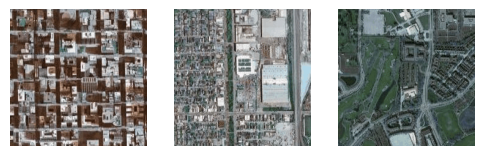

In [7]:
fig, ax = plt.subplots(1,3, figsize=(6,2))
ax[0].imshow(util_image.center_crop(cv2.imread(im1), (224,224)))
ax[1].imshow(util_image.center_crop(cv2.imread(im2), (224,224)))
ax[2].imshow(util_image.center_crop(cv2.imread(im3), (224,224)))
ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")
plt.show()

### 1. Latent Space Dimension Reduction

In [14]:
with open(proj_dir+"latent_space/SAE_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                       v1+"_"+str(v2)+"_"+model_run_date+".pkl", "rb") as f: 
    encoder_output = pkl.load(f)
    im = pkl.load(f)
    ct = pkl.load(f)

In [15]:
unique_ct = list(set(ct))
unique_ct.sort()
ct = np.array(ct)
aggregate_embeddings = []
for i in unique_ct:
    aggregate_embeddings.append(np.mean(encoder_output[ct == i], axis=0))
aggregate_embeddings = np.array(aggregate_embeddings)

In [13]:
index1 = unique_ct.index(dt)
index2 = unique_ct.index(south)
index3 = unique_ct.index(north)

agg_enc1 = aggregate_embeddings[index1,:]
agg_enc2 = aggregate_embeddings[index2,:]
agg_enc3 = aggregate_embeddings[index3,:]

In [14]:
enc12 = []
enc13 = []
for alpha in np.linspace(0, 1, 20):
    enc12.append((1-alpha)*agg_enc1+alpha*agg_enc2)
    enc13.append((1-alpha)*agg_enc1+alpha*agg_enc3)

enc12 = np.vstack(enc12)
enc13 = np.vstack(enc13)

In [15]:
# tSNE
from sklearn import manifold
method = manifold.TSNE(n_components=2, init='pca', random_state=1)
# tsne_im = method.fit_transform(encoder_output)
# tsne_ct = method.fit_transform(np.concatenate([aggregate_embeddings, enc12, enc13], axis=0))
tsne_ct = method.fit_transform(aggregate_embeddings)

/home/jtl/anaconda3/envs/dingyi_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/jtl/anaconda3/envs/dingyi_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [16]:
a = tsne_ct

In [17]:
north_idx = unique_ct.index(north)

south_idx = unique_ct.index(south)

dt_idx = unique_ct.index(dt)

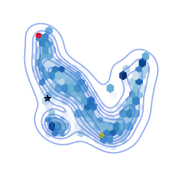

In [18]:
fig, ax = plt.subplots(1,1,figsize=(3,3))
hexagons = ax.hexbin(a[:,0], a[:,1], gridsize=17, mincnt=1, cmap='Blues')
sns.kdeplot(x=a[:,0], y=a[:,1], ax=ax, levels=7, color='royalblue', alpha=0.5)
# ax.plot(tsne12[:,0], tsne12[:,1], c='r')
# ax.plot(tsne13[:,0], tsne13[:,1], c='g')
ax.scatter(a[north_idx,0], a[north_idx,1], c='y',s=20)
ax.scatter(a[dt_idx,0], a[dt_idx,1], c='r',s=20)
ax.scatter(a[south_idx,0], a[south_idx,1], marker='*', c='k',s=40)

plt.axis("off")
plt.show()

fig.savefig(out_dir+"latent_space/SAE_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                           v1+"_"+model_run_date+"_traj.png", bbox_inches='tight')

### PCA 
from sklearn.decomposition import PCA
m = PCA(n_components=2)
m.fit(aggregate_embeddings)

In [ ]:
apca = m.transform(aggregate_embeddings)
fig, ax = plt.subplots(1,1,figsize=(3,3))
hexagons = ax.hexbin(apca[:,0], apca[:,1], gridsize=17, mincnt=1, cmap='Blues')
sns.kdeplot(x=apca[:,0], y=apca[:,1], ax=ax, levels=7, color='royalblue', alpha=0.5)

t1 = m.transform(enc12)
plt.plot(t1[:,0], t1[:,1], c='cornflowerblue')
t2 = m.transform(enc13)
plt.plot(t2[:,0], t2[:,1], c='salmon')

plt.axis("off")
plt.show()

# fig.savefig(out_dir+"image_samples/image_complex/"+model_type+"_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+
#                     model_run_date+"_latent_traj_"+
#                     image_name1+"_mix_"+image_name2+"_mix_"+image_name3+".png", 
#                     bbox_inches='tight')

### 2. Image Complex

In [10]:
from mnl import MNL
model_mnl = MNL(n_alts=4, n_features=output_dim**2*2048)
# saved = torch.load(out_dir+"models/zoom15_18432_D_1_2208_3_0.0001_0.001.pt")
saved = torch.load(out_dir+"models/sae_a_D_1_220829.pt")

model_mnl.load_state_dict(saved);
model_mnl.to(torch.device(device))

MNL(
  (beta): Linear(in_features=18432, out_features=4, bias=True)
)

In [11]:
mult_list = np.arange(0,1.8,0.2)

mult_list

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6])

In [12]:
if int(im_norm) != 0:
    if int(im_norm) == 1:
        if zoomlevel == 'zoom13':
            mean = [0.3733, 0.3991, 0.3711]
            std = [0.2173, 0.2055, 0.2143]
        elif zoomlevel == 'zoom15':
            mean = [0.3816, 0.4169, 0.3868]
            std = [0.1960, 0.1848, 0.2052]

    elif int(im_norm) == 2:
        mean = [0.5,0.5,0.5]
        std = [0.5,0.5,0.5]

In [16]:
torch.softmax(model_mnl(torch.tensor(aggregate_embeddings).to(device)), dim=1).mean(dim=0)

tensor([0.1185, 0.7699, 0.0412, 0.0704], device='cuda:0',
       grad_fn=<MeanBackward1>)

In [133]:
dec_imgs = []
demos = []
logsums = []
auto_ = []
pt_ = []
active_ = []

for alpha in mult_list:
    row = []
    logsum_row = []
    img_row = []
    auto_row = []
    pt_row = []
    active_row = []
    
    for beta in mult_list:
        enc = enc2 + alpha*(enc3-enc2) + beta*(enc1-enc2)
#         enc = enc1 + alpha*(enc2-enc1) + beta*(enc3-enc1)
        dec, dec_demo = model(x=None, xp=enc)
#         enc = enc.cpu()
        
        util = model_mnl(enc)
        util = util.cpu().detach().numpy()
        auto_row.append(np.exp(util)[0][1]/np.sum(np.exp(util)))
        pt_row.append(np.exp(util)[0][3]/np.sum(np.exp(util)))
        active_row.append(np.exp(util)[0][0]/np.sum(np.exp(util)))

        util = np.log(np.sum(np.exp(util)))
        logsum_row.append(util)
        
        img = util_image.inverse_transform(dec, mean, std)[0].permute(1,2,0).detach().cpu().numpy()
#         im_sharp = cv2.filter2D(src=img, ddepth=-1, kernel=sharpen_kernel)
#         im_sharp = cv2.filter2D(src=im_sharp, ddepth=-1, kernel=sharpen_kernel)
        img_row.append(np.clip(img,0,1))
        
        row.append(dec_demo.detach().cpu().numpy())
        
    demos.append(row)
    logsums.append(logsum_row)
    dec_imgs.append(img_row)
    auto_.append(auto_row)
    pt_.append(pt_row)
    active_.append(active_row)
    
# demos = np.array(demos)


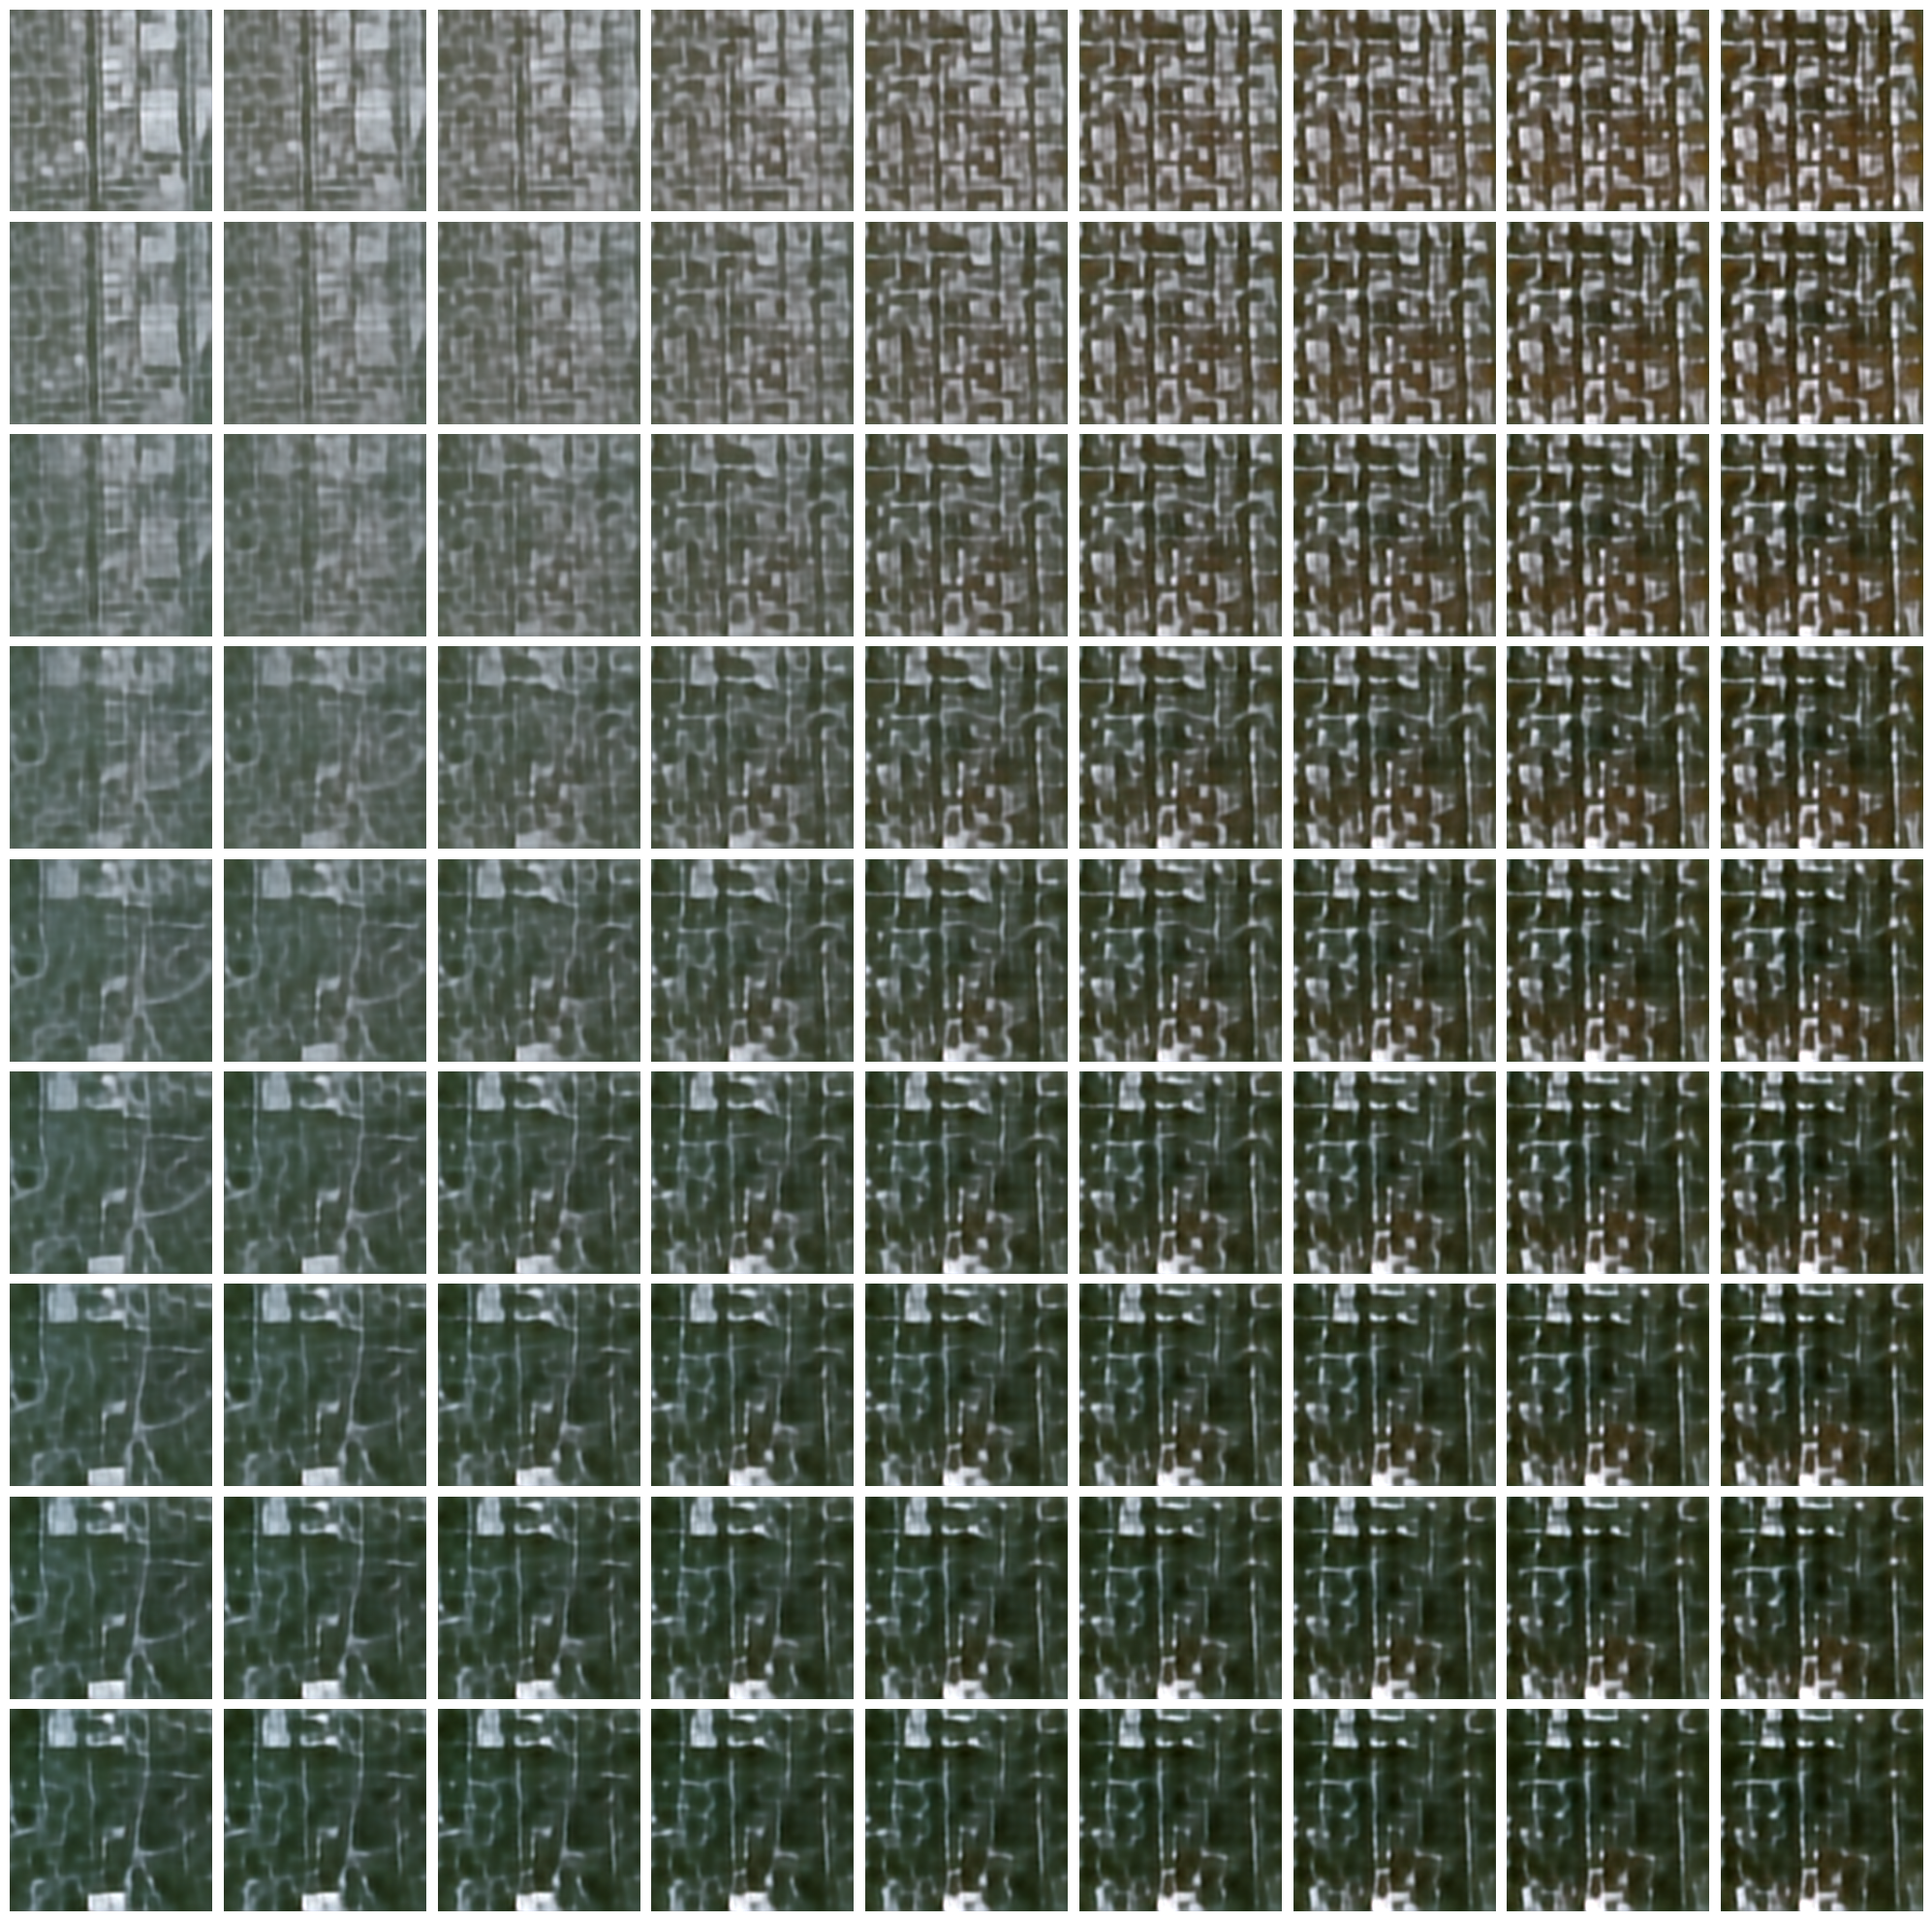

In [134]:
fig, ax = util_plot.plot_images(len(mult_list), len(mult_list), dec_imgs, mag=3)
plt.show()

In [135]:
fig.savefig(out_dir+"image_samples/image_complex/"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+v1+"_"+str(v2)+"_"+
                    model_run_date+"_interpolation_"+
                    image_name1+"_mix_"+image_name2+"_mix_"+image_name3+"_"+str(len(mult_list))+".png", 
                    bbox_inches='tight')


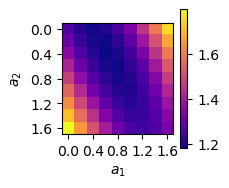

In [141]:
fig, ax = plt.subplots(1,1, figsize=(1.8,1.8))
plt.imshow(np.array(logsums),cmap="plasma")
ax.set_xticks(np.arange(0,len(mult_list),2))
ax.set_xticklabels(["{:.1f}".format(a) for a in np.arange(0,1.7,0.4)])
ax.set_yticks(np.arange(0,len(mult_list),2))
ax.set_yticklabels(["{:.1f}".format(a) for a in np.arange(0,1.7,0.4)])
ax.set_ylabel(r"$a_2$")
ax.set_xlabel(r"$a_1$")
plt.colorbar()
plt.show()
fig.savefig(out_dir+"image_samples/image_complex/"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+
                    model_run_date+"_welfare_complex_"+
                    image_name1+"_mix_"+image_name2+"_mix_"+image_name3+".png", 
                    bbox_inches='tight')

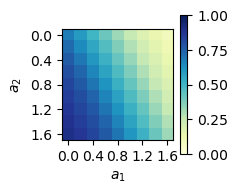

In [142]:
fig, ax = plt.subplots(1,1, figsize=(1.8,1.8))
plt.imshow(np.array(auto_),cmap="YlGnBu", vmin=0,vmax=1)
ax.set_xticks(np.arange(0,len(mult_list),2))
ax.set_xticklabels(["{:.1f}".format(a) for a in np.arange(0,1.7,0.4)])
ax.set_yticks(np.arange(0,len(mult_list),2))
ax.set_yticklabels(["{:.1f}".format(a) for a in np.arange(0,1.7,0.4)])
ax.set_ylabel(r"$a_2$")
ax.set_xlabel(r"$a_1$")
plt.colorbar()
plt.show()
fig.savefig(out_dir+"image_samples/image_complex/"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+
                    model_run_date+"_auto_complex_"+
                    image_name1+"_mix_"+image_name2+"_mix_"+image_name3+".png", 
                    bbox_inches='tight')

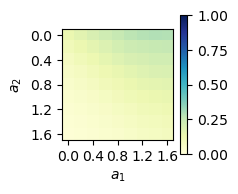

In [143]:
fig, ax = plt.subplots(1,1, figsize=(1.8,1.8))
plt.imshow(np.array(pt_),cmap="YlGnBu", vmin=0,vmax=1)
ax.set_xticks(np.arange(0,len(mult_list),2))
ax.set_xticklabels(["{:.1f}".format(a) for a in np.arange(0,1.7,0.4)])
ax.set_yticks(np.arange(0,len(mult_list),2))
ax.set_yticklabels(["{:.1f}".format(a) for a in np.arange(0,1.7,0.4)])
ax.set_ylabel(r"$a_2$")
ax.set_xlabel(r"$a_1$")
plt.colorbar()
plt.show()
fig.savefig(out_dir+"image_samples/image_complex/"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+
                    model_run_date+"_pt_complex_"+
                    image_name1+"_mix_"+image_name2+"_mix_"+image_name3+".png", 
                    bbox_inches='tight')

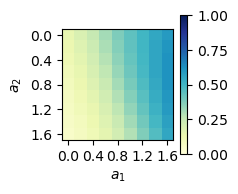

In [144]:
fig, ax = plt.subplots(1,1, figsize=(1.8,1.8))
plt.imshow(np.array(active_),cmap="YlGnBu", vmin=0,vmax=1)
ax.set_xticks(np.arange(0,len(mult_list),2))
ax.set_xticklabels(["{:.1f}".format(a) for a in np.arange(0,1.7,0.4)])
ax.set_yticks(np.arange(0,len(mult_list),2))
ax.set_yticklabels(["{:.1f}".format(a) for a in np.arange(0,1.7,0.4)])
ax.set_ylabel(r"$a_2$")
ax.set_xlabel(r"$a_1$")
plt.colorbar()
plt.show()
fig.savefig(out_dir+"image_samples/image_complex/"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+
                    model_run_date+"_active_complex_"+
                    image_name1+"_mix_"+image_name2+"_mix_"+image_name3+".png", 
                    bbox_inches='tight')

## 3. Latent Space Directional Move

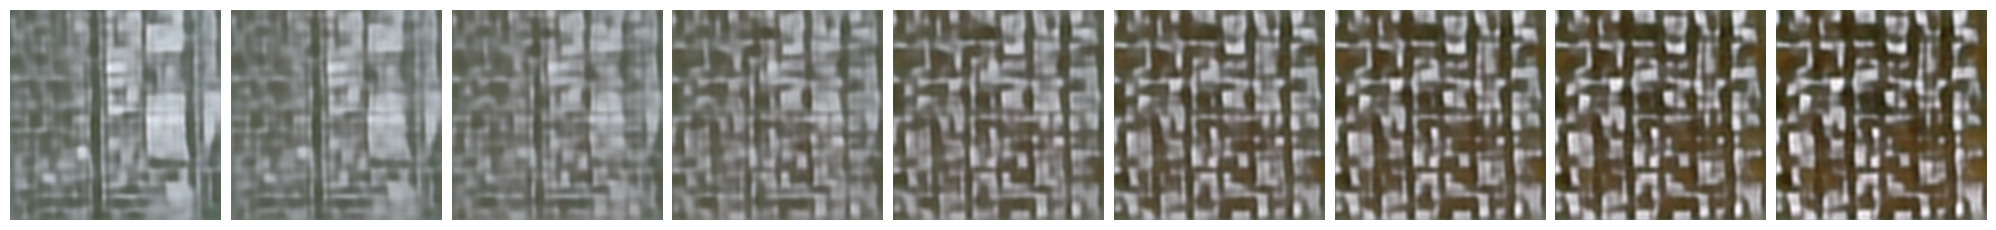

In [132]:
fig, ax = util_plot.plot_images(1, len(mult_list), [dec_imgs[i][0] for i in range(len(dec_imgs))], mag=3)

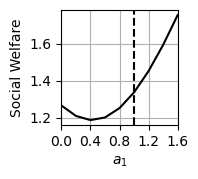

In [148]:
fig, ax = plt.subplots(1,1, figsize=(1.5,1.5))
ax.plot(mult_list, logsums[0], color='k')
ax.set_ylabel("Social Welfare")
ax.set_xlabel(r'$a_1$')
# ax.legend()
ax.set_xlim([0,1.6])
ax.set_xticks(np.arange(0,1.7,0.4))
ylim = ax.get_ylim()
ax.plot([1,1], ylim, '--', color='k',)

ax.set_ylim(ylim)
ax.grid()
plt.show()
fig.savefig(out_dir+"image_samples/interpolation/"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+
                    model_run_date+"_welfare_"+
                    image_name1+"_mix_"+image_name2+".png", 
                    bbox_inches='tight')

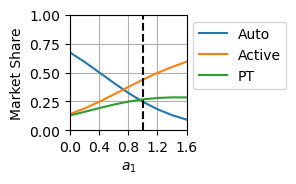

In [157]:
fig, ax = plt.subplots(1,1, figsize=(1.5,1.5))
ax.plot(mult_list, [auto_[0][i] for i in range(len(auto_))], label='Auto')
ax.plot(mult_list, [active_[0][i] for i in range(len(auto_))], label='Active')
ax.plot(mult_list, [pt_[0][i] for i in range(len(auto_))], label='PT')
ax.set_ylabel("Market Share")
ax.set_xlabel(r'$a_1$')
ax.legend(bbox_to_anchor=(1,1));

ax.set_xlim([0,1.6])
ax.set_xticks(np.arange(0,1.7,0.4))
ylim = [0,1]
ax.plot([1,1], ylim, '--', color='k',)
ax.set_ylim([0,1])
ax.grid()
plt.show()
fig.savefig(out_dir+"image_samples/interpolation/"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+
                    model_run_date+"_market_"+
                    image_name1+"_mix_"+image_name2+".png", 
                    bbox_inches='tight')

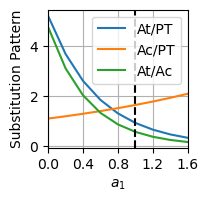

In [151]:
fig, ax = plt.subplots(1,1, figsize=(1.8,1.8))
ax.plot(mult_list, [auto_[0][i]/pt_[0][i] for i in range(len(auto_))], label='At/PT')
ax.plot(mult_list, [active_[0][i]/pt_[0][i] for i in range(len(auto_))], label='Ac/PT')
ax.plot(mult_list, [auto_[0][i]/active_[0][i] for i in range(len(auto_))], label='At/Ac')
ax.set_ylabel("Substitution Pattern")
ax.set_xlabel(r'$a_1$')
ax.legend()
ax.set_xticks(np.arange(0,1.7,0.4))
ax.set_xlim([0,1.6])
ylim = ax.get_ylim()
ax.plot([1,1], ylim, '--', color='k',)

ax.set_ylim(ylim)
ax.grid()
plt.show()
fig.savefig(out_dir+"image_samples/interpolation/"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+
                    model_run_date+"_substitution_"+
                    image_name1+"_mix_"+image_name2+".png", 
                    bbox_inches='tight')

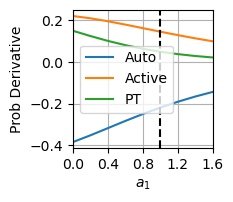

In [153]:
u = (enc1-enc2)[0]

fig, ax = plt.subplots(1,1, figsize=(1.8,1.8))

for k,n in zip([1,0,3], ['Auto','Active','PT']):
    pd = []
    for alpha in mult_list:
        prob_derivative = 0

        enc = enc2 + alpha*(enc3-enc2)

        util = model_mnl(enc)
        prob = torch.softmax(util, dim=1)

        for j in range(4):
            if j == k:
                prob_derivative += model_mnl.beta.weight[k,:] * prob[0,k] * (1-prob[0,k])
            else:
                prob_derivative -= model_mnl.beta.weight[j,:] * prob[0,k] * prob[0,j]

        pd.append(torch.dot(prob_derivative, u).detach().cpu().numpy())
    
    ax.plot(mult_list, pd, label = n)

ylim = ax.get_ylim()
ax.plot([1,1], ylim, '--', color='k',)
ax.set_ylabel("Prob Derivative")
ax.set_xlabel(r'$a_1$')
ax.legend()
ax.set_xticks(np.arange(0,1.7,0.4))
ax.set_xlim([0,1.6])
ax.set_ylim(ylim)
ax.grid()
plt.show()
fig.savefig(out_dir+"image_samples/interpolation/"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+
                    model_run_date+"_probdev_"+
                    image_name1+"_mix_"+image_name2+".png", 
                    bbox_inches='tight')

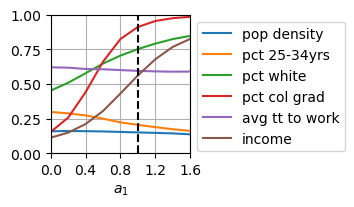

In [156]:
demos = np.squeeze(np.array(demos))
# demos_norm = (demos-demos.min(axis=0))/(demos.max(axis=0)-demos.min(axis=0))
# demos_norm = demos_norm.T

demo_variables = ['pop density','pct 25-34yrs','pct35_50yrs','pctover65yrs',
         'pct white', 'pct non-white',
         'pct black',
         'pct col grad','avg tt to work','income']

fig, ax = plt.subplots(figsize=(1.8,1.8))
# im = ax.imshow(demos[0,:].T, cmap='YlGnBu')
for i in [0,1,4,7,8,9]:
# for i in range(10):
    ax.plot(mult_list, demos[:,0,i], label=demo_variables[i])
    
ax.set_xticks(np.arange(0,1.7,0.4))
ax.set_xlabel(r'$a_1$')
ax.set_xlim([0,1.6])
ylim = [0,1]
ax.plot([1,1], ylim, '--', color='k',)

ax.set_ylim([0,1])
ax.grid()
ax.legend(bbox_to_anchor=(1,1));
fig.savefig(out_dir+"image_samples/interpolation/"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+
                    model_run_date+"_social_"+
                    image_name1+"_mix_"+image_name2+".png", 
                    bbox_inches='tight')